# Discrete Logarithm

The Discrete Logarithm Problem [[1](#DiscreteLog)] was shown by Shor [[2](#Shor)] to be solved in a polynomial time using quantum computers, while the fastest classical algorithms take a superpolynomial time. The problem is at least as hard as the factoring problem. In fact, the hardness of the problem is the basis for the Diffie-Hellman [[3](#DiffieHellman)] protocol for key exchange. 

## Formulating the Problem

* **Input:** A cyclic group $G = \langle g \rangle$ with $g$ as a generator, and an element $x\in G$.

* **Promise:**  There is a number $s$ such that $g^s = x$.

* **Output:** $s$, the discrete logarithm: $s = \log_gx$.

*** 

In Shor's implementation, the order of $g$ is assumed to be known beforehand (for example, using the order finding algorithm). We also assume it in the demonstration. 

The Discrete Log problem is a specific example of the Abelian Hidden Subgroup Problem [[4](#HSP)] for the case of an additive group, with this function:
$$
f: \mathbb{Z}_N \times \mathbb{Z}_N \rightarrow G
$$
$$
f(\alpha, \beta) = x^\alpha g^\beta
$$

## Building the Algorithm with Classiq

The heart of the algorithm's logic is the implementation of the function
$$
|x_1\rangle|x_2\rangle|1\rangle \rightarrow |x_1\rangle|x_2\rangle|x^{x_1} g^{x_2}\rangle. 
$$

This is done using two applications of the modular exponentiation function, described in detail in the [Shor's Factoring Algorithm](https://short.classiq.io/shor) notebook. So here we import it from the Classiq library.

The `modular_exp` function accepts these arguments:
- `n: CInt` - modulo number
- `a: CInt` - base of the exponentiation
- `x: QArray[QBit]` - unsigned integer to multiply by the exponentiation
- `power: QArray[QBit]`- power of the exponentiation

So the function implements 
$|power\rangle|x\rangle \rightarrow |power\rangle|x \cdot a ^ {power}\mod n\rangle$.

In [1]:
from classiq import *


@qfunc
def discrete_log_oracle(
    g_generator: CInt,
    x_element: CInt,
    N_modulus: CInt,
    x1: QArray,
    x2: QArray,
    func_res: Output[QNum],
) -> None:
    allocate(ceiling(log(N_modulus, 2)), func_res)

    func_res ^= 1
    modular_exp(N_modulus, x_element, func_res, x1)
    modular_exp(N_modulus, g_generator, func_res, x2)

### Full Algorithm
1. Prepare uniform superposition over the first two quantum variables `x1`, `x2`. Each variable has size $\lceil \log r\rceil + \log({1/{\epsilon}})$. In the special case where $r$ is a power of 2,  $\log r$ is enough.
3. Compute `discrete_log_oracle` on the `func_res` variable. `func_res` is of size $\lceil \log N\rceil$.
4. Apply the inverse Fourier transform `x1`, `x2`.
5. Measure.

In [2]:
from classiq.qmod.symbolic import ceiling, log


@qfunc
def discrete_log(
    g: CInt,
    x: CInt,
    N: CInt,
    order: CInt,
    x1: Output[QArray],
    x2: Output[QArray],
    func_res: Output[QArray],
) -> None:
    reg_len = ceiling(log(order, 2))
    allocate(reg_len, x1)
    allocate(reg_len, x2)

    hadamard_transform(x1)
    hadamard_transform(x2)

    discrete_log_oracle(g, x, N, x1, x2, func_res)

    invert(lambda: qft(x1))
    invert(lambda: qft(x2))

After the inverse QFTs (under the assumption of $r=2^m$ for some $m$), the variables become
$$|\psi\rangle = \sum_{\nu\in\mathbb{Z}_r, \delta\in G}\omega^{\nu\delta}|\nu\cdot log_gx\rangle_{x_1}|\nu\rangle_{x_2}|\delta>_{func\_res}$$.

For every $\nu$ that has a multiplicative inverse in $\mathbb{Z}_r$, we can extract $s=\log_xg$ by multiplying the first variable result by its inverse.

If $r$ is not a power of 2, the variables get an approximation of |$\log_g(x)\cdot \nu/ r\rangle_{x_1} |\nu / r\rangle_{x_2}$. So we can use the continued fractions algorithm [[5](#ContinuedFraction)] to compute $\nu/r$, then use the same technique to calculate $\log_gx$.

*Note: Alternatively, you could implement the $QFT_{\mathbb{Z}_r}$ over general $r$, and instead of the uniform superposition, prepare the states: $\frac{1}{\sqrt{r}}\sum_{x\in\mathbb{r}}|x\rangle$ in `x1`, `x2`. Then, again, no continued fractions postprocessing is required.*

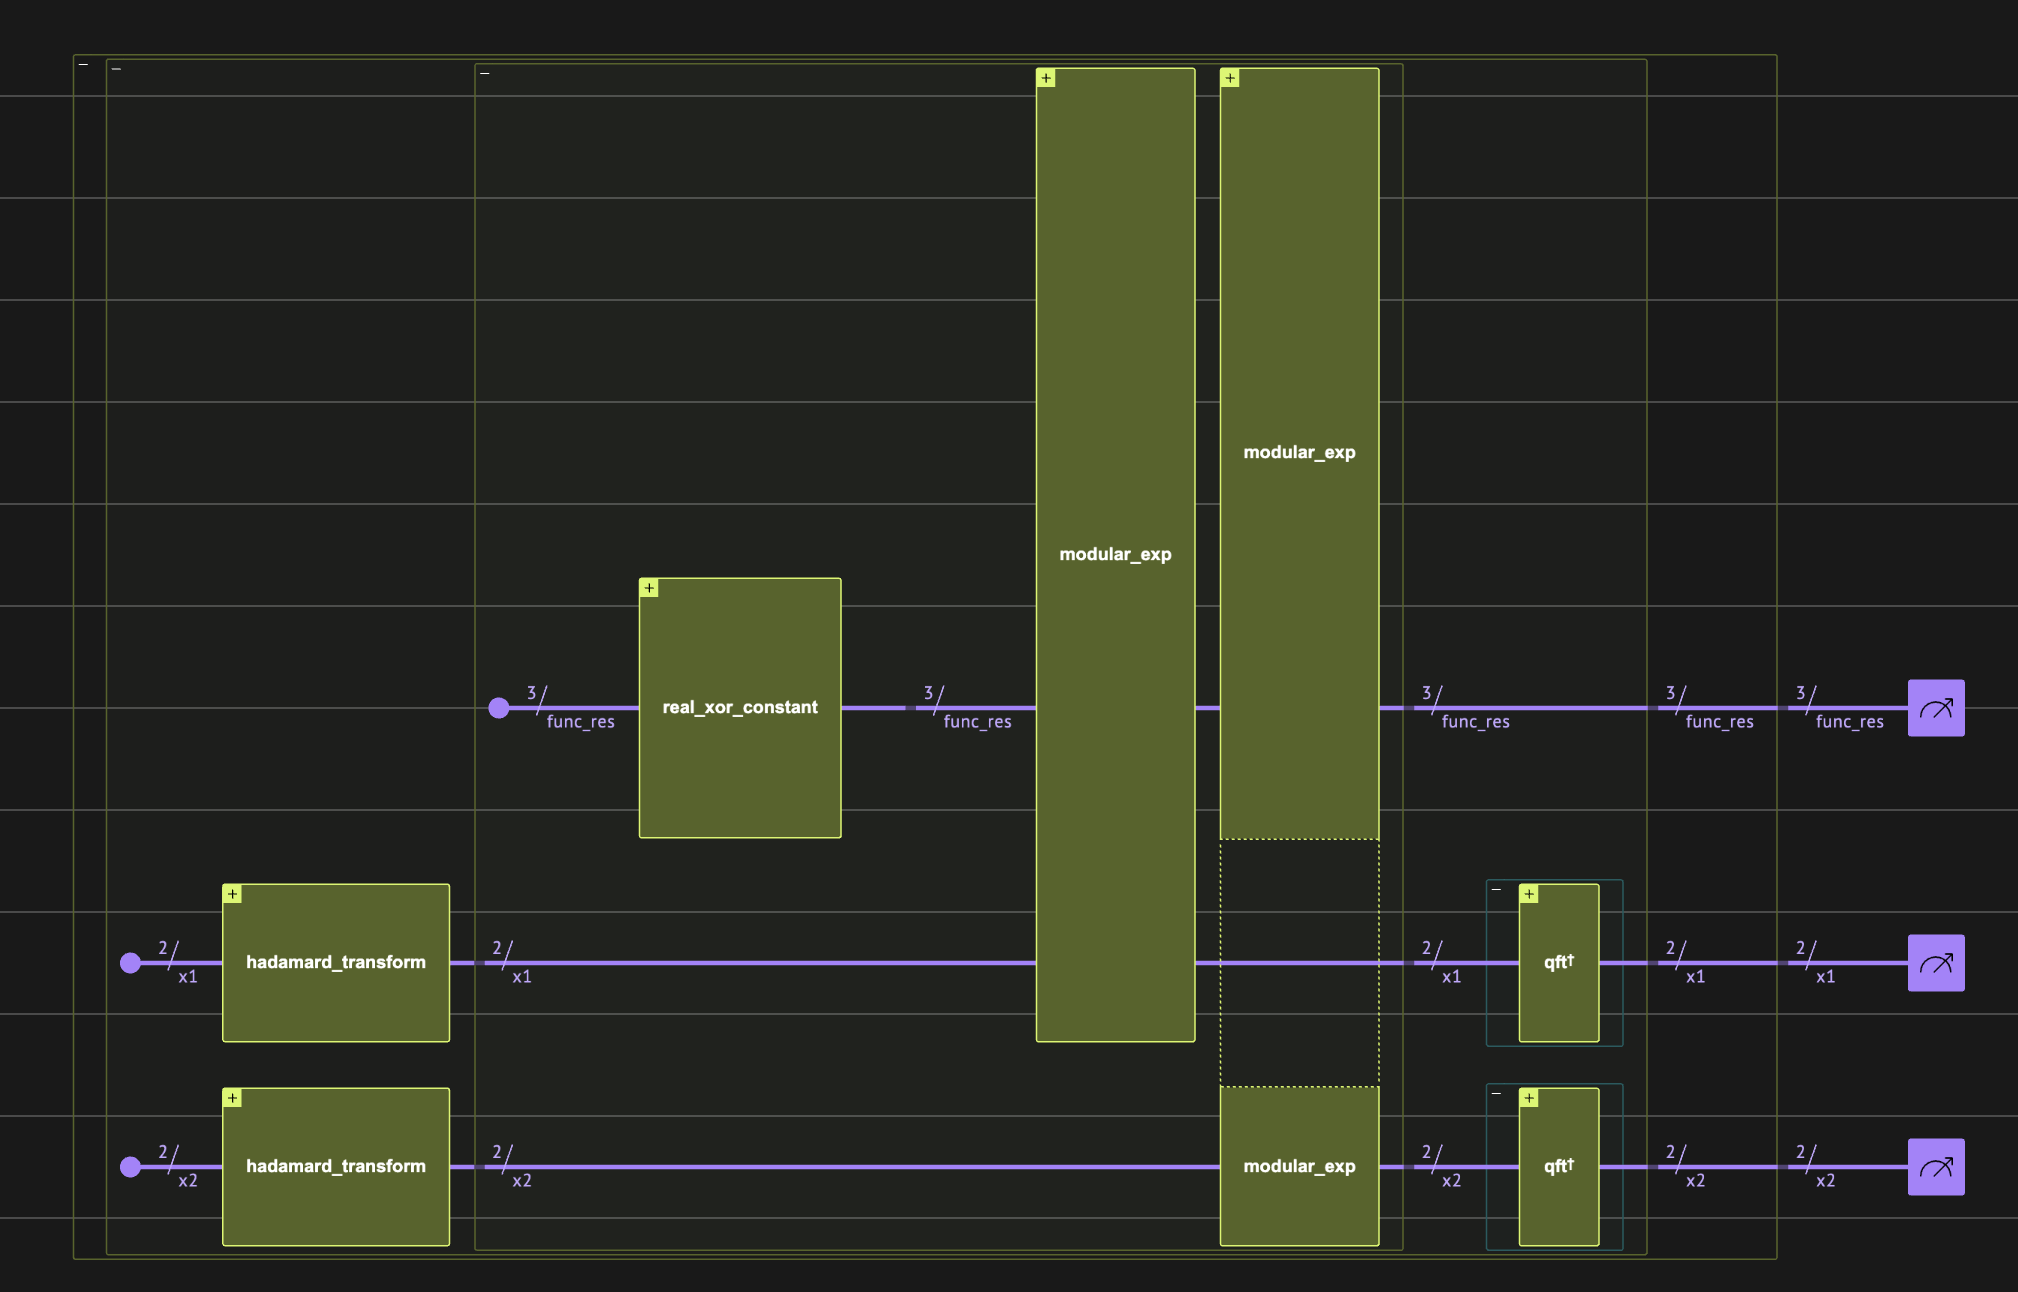

## Example:  $G = \mathbb{Z}_5^\times$

For this specific demonstration, we choose $G = \mathbb{Z}_5^\times$, with $g=3$ and $x=2$. With this setting, $log_gx=3$.

We choose this specific example because the order of the group $r=4$ is a power of $2$, so we can get the exact discrete logarithm without continued-fractions postprocessing. In other cases, we use a larger quantum variable for the exponents so the continued fractions postprocessing converges.

In [32]:
MODULU_NUM = 5
G_GENERATOR = 3
X_LOG_ARG = 2
ORDER = MODULU_NUM - 1  # as 5 is prime


@qfunc
def main(
    x1: Output[QNum],
    x2: Output[QNum],
    func_res: Output[QNum],
) -> None:
    discrete_log(G_GENERATOR, X_LOG_ARG, MODULU_NUM, ORDER, x1, x2, func_res)

In [7]:
from classiq.execution import ExecutionPreferences

constraints = 
qmod_Z5 = create_model(
    main,
    constraints=Constraints(max_width=13),
    preferences=Preferences(optimization_level=1)
    execution_preferences=ExecutionPreferences(num_shots=4000),
    out_file="discrete_log",
)

qprog_Z5 = synthesize(qmod_Z5)
show(qprog_Z5)

Quantum program link: https://platform.classiq.io/circuit/2yd6JJsnBpziWbW70YRaz6d1R4z


In [8]:
result_Z5 = execute(qprog_Z5).result_value()
result_Z5.parsed_counts

[{'x1': 2, 'x2': 2, 'func_res': 2}: 281,
 {'x1': 0, 'x2': 0, 'func_res': 3}: 272,
 {'x1': 2, 'x2': 2, 'func_res': 3}: 270,
 {'x1': 2, 'x2': 2, 'func_res': 1}: 266,
 {'x1': 3, 'x2': 1, 'func_res': 4}: 258,
 {'x1': 0, 'x2': 0, 'func_res': 1}: 256,
 {'x1': 3, 'x2': 1, 'func_res': 1}: 254,
 {'x1': 0, 'x2': 0, 'func_res': 2}: 252,
 {'x1': 3, 'x2': 1, 'func_res': 2}: 251,
 {'x1': 0, 'x2': 0, 'func_res': 4}: 244,
 {'x1': 1, 'x2': 3, 'func_res': 4}: 241,
 {'x1': 1, 'x2': 3, 'func_res': 3}: 238,
 {'x1': 2, 'x2': 2, 'func_res': 4}: 237,
 {'x1': 1, 'x2': 3, 'func_res': 1}: 228,
 {'x1': 3, 'x2': 1, 'func_res': 3}: 228,
 {'x1': 1, 'x2': 3, 'func_res': 2}: 224]

Note that `func_res` is uncorrelated to the other variables, and we get uniform distribution, as expected. 

We take only the `x2` that are co-prime to $r=4$, so they have a multiplicative-inverse. Hence `x2=1,3` are the relevant results.
So we get two relevant results (for all different $\delta$s): $|1\rangle|3\rangle$, $|3\rangle|1\rangle$. All that remains to get the logarithm is to multiply `x1` by the inverse of `x2`:

In [33]:
for res in result_Z5.parsed_counts:
    if res.state["x2"] in [1, 3]:
        logarithm = res.state["x2"] * pow(res.state["x1"], -1, 4)
        assert logarithm == 3

Verify we received the correct discrete logarithm:

In [36]:
log_arg = (G_GENERATOR**logarithm) % MODULU_NUM
print(log_arg)
assert log_arg == X_LOG_ARG

2


And, indeed, both cases give the same result, which is exactly the discrete logarithm: $\log_32 \mod 5 = 3$.

## Example:  $G = \mathbb{Z}_{13}^\times$

In this case the order is not a power of 2. During circuit creation, we change the state preparation: instead of creating the entire uniform distribution on the `x1`, `x2` variables, we load them with the uniform superposition of only the first `#ORDER` states.

We do that using the `prepare_uniform_trimmed_state` library function, which efficiently prepares such a state.

In [9]:
MODULU_NUM = 13
G_GENERATOR = 7
X_LOG_ARG = 3
ORDER = 12


@qfunc
def discrete_log(
    g: CInt,
    x: CInt,
    N: CInt,
    order: CInt,
    x1: Output[QNum],
    x2: Output[QNum],
    func_res: Output[QNum],
) -> None:
    reg_len = ceiling(log(order, 2)) + 1

    # we define the variables with fraction places to ease the postprocessing
    allocate(reg_len, False, reg_len, x1)
    allocate(reg_len, False, reg_len, x2)

    prepare_uniform_trimmed_state(ORDER, x1)
    prepare_uniform_trimmed_state(ORDER, x2)

    discrete_log_oracle(g, x, N, x1, x2, func_res)

    invert(lambda: qft(x1))
    invert(lambda: qft(x2))


@qfunc
def main(
    x1: Output[QNum],
    x2: Output[QNum],
    func_res: Output[QNum],
) -> None:
    discrete_log(G_GENERATOR, X_LOG_ARG, MODULU_NUM, ORDER, x1, x2, func_res)

In [12]:
constraints = Constraints(max_width=23)
preferences = Preferences(optimization_level=1)
execution_preferences = ExecutionPreferences(num_shots=10000)
qmod_Z13 = create_model(
    main,
    constraints=constraints,
    preferences=preferences,
    execution_preferences=execution_preferences,
    out_file="discrete_log_large",
)

qprog_Z13 = synthesize(qmod_Z13)
show(qprog_Z13)

Quantum program link: https://platform.classiq.io/circuit/2ydA5MAc3vlht9PWDcdXD9SB4dr


In [13]:
result_Z13 = execute(qprog_Z13).result_value()
result_Z13.parsed_counts[:10]

[{'x1': 0.34375, 'x2': 0.90625, 'func_res': 3}: 17,
 {'x1': 0.0, 'x2': 0.0, 'func_res': 8}: 17,
 {'x1': 0.34375, 'x2': 0.15625, 'func_res': 10}: 17,
 {'x1': 0.0, 'x2': 0.0, 'func_res': 3}: 17,
 {'x1': 0.34375, 'x2': 0.4375, 'func_res': 10}: 16,
 {'x1': 0.6875, 'x2': 0.59375, 'func_res': 4}: 16,
 {'x1': 0.65625, 'x2': 0.09375, 'func_res': 3}: 16,
 {'x1': 0.34375, 'x2': 0.40625, 'func_res': 3}: 15,
 {'x1': 0.65625, 'x2': 0.34375, 'func_res': 5}: 15,
 {'x1': 0.34375, 'x2': 0.40625, 'func_res': 4}: 15]

#### Postprocessing

We now have an additional step in postprocessing. We translate each result to the closest fraction with a denominator, which is the order:

In [14]:
def closest_fraction(x, denominator):
    return round(x * denominator)


parsed = []
for r in result_Z13.parsed_counts[:30]:
    x1 = closest_fraction(r.state["x1"], ORDER)
    x2 = closest_fraction(r.state["x2"], ORDER)
    rounded = {"x1": x1, "x2": x2, "shots": r.shots}
    parsed.append(rounded)
    print(rounded)

{'x1': 4, 'x2': 11, 'shots': 17}
{'x1': 0, 'x2': 0, 'shots': 17}
{'x1': 4, 'x2': 2, 'shots': 17}
{'x1': 0, 'x2': 0, 'shots': 17}
{'x1': 4, 'x2': 5, 'shots': 16}
{'x1': 8, 'x2': 7, 'shots': 16}
{'x1': 8, 'x2': 1, 'shots': 16}
{'x1': 4, 'x2': 5, 'shots': 15}
{'x1': 8, 'x2': 4, 'shots': 15}
{'x1': 4, 'x2': 5, 'shots': 15}
{'x1': 4, 'x2': 11, 'shots': 14}
{'x1': 0, 'x2': 6, 'shots': 14}
{'x1': 8, 'x2': 7, 'shots': 14}
{'x1': 4, 'x2': 2, 'shots': 14}
{'x1': 8, 'x2': 7, 'shots': 14}
{'x1': 4, 'x2': 11, 'shots': 14}
{'x1': 8, 'x2': 7, 'shots': 14}
{'x1': 8, 'x2': 10, 'shots': 14}
{'x1': 4, 'x2': 2, 'shots': 14}
{'x1': 8, 'x2': 4, 'shots': 14}
{'x1': 8, 'x2': 1, 'shots': 14}
{'x1': 0, 'x2': 6, 'shots': 14}
{'x1': 0, 'x2': 3, 'shots': 14}
{'x1': 0, 'x2': 3, 'shots': 14}
{'x1': 4, 'x2': 2, 'shots': 14}
{'x1': 8, 'x2': 4, 'shots': 14}
{'x1': 4, 'x2': 5, 'shots': 13}
{'x1': 8, 'x2': 1, 'shots': 13}
{'x1': 0, 'x2': 9, 'shots': 13}
{'x1': 4, 'x2': 8, 'shots': 13}


Now, we take a sample where `x2` is co-prime to the order, such that we can get the logarithm by multiplying `x1` by the modular inverse. If the `x1`, `x2` registers are large enough, we are guaranteed to sample it with a good probability:

In [15]:
logarithm = None
for sample in parsed:
    try:
        inverse = pow(sample["x2"], -1, ORDER)
        logarithm = sample["x1"] * inverse % ORDER
        print(sample)
        print("Inverse:", inverse, "Logarithm:", logarithm)
        break
    except:
        continue

{'x1': 4, 'x2': 11, 'shots': 17}
Inverse: 11 Logarithm: 8


In [16]:
assert logarithm is not None
assert G_GENERATOR**logarithm % MODULU_NUM == X_LOG_ARG

## References

<a id='DiscreteLog'>[1]</a>: [Discrete Logarithm (Wikipedia)](https://en.wikipedia.org/wiki/Discrete_logarithm)

<a id='Shor94'>[2]</a>: [Shor, Peter W. "Algorithms for quantum computation: discrete logarithms and factoring." Proceedings 35th annual symposium on foundations of computer science. IEEE, 1994.](https://ieeexplore.ieee.org/abstract/document/365700)

<a id='DiffieHellman'>[3]</a>: [Diffie-Hellman Key Exchange (Wikipedia)](https://en.wikipedia.org/wiki/Diffie%E2%80%93Hellman_key_exchange)

<a id='HSP'>[4]</a>: [Hidden Subgroup Problem (Wikipedia)](https://en.wikipedia.org/wiki/Hidden_subgroup_problem)

<a id='ContinuedFraction'>[5]</a>: [Continued Fraction (Wikipedia)](https://en.wikipedia.org/wiki/Continued_fraction)
